In [274]:
import torch
import torch.nn as nn


import pandas as pd
import numpy as np
import mediapipe as mp
import cv2

from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from tqdm import tqdm
from sklearn.preprocessing import OneHotEncoder

from sklearn.metrics import(
    accuracy_score, 
    confusion_matrix, 
    ConfusionMatrixDisplay,
    f1_score, 
    precision_score, 
    recall_score, 
)

In [197]:
# Connect to the GPU if one exists.
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print("Using: ", device)
torch.cuda.empty_cache()

Using:  cuda


In [268]:
mp_hollistic = mp.solutions.holistic
mp_model = mp_hollistic.Holistic(min_detection_confidence=0, min_tracking_confidence=0)

In [281]:
def mediapipe_detection(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image.flags.writeable = False
    
    results = mp_model.process(image)
    
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    
    return results

def extract_paths_and_labels(file_name):
    f = open(file_name, "r")
    paths  = []
    labels = []
    for line in f.readlines():
        path_and_label = line.split(" ")
        
        path = path_and_label[0]
        label = path_and_label[1]
        
        paths.append(path)
        labels.append(label)
    
    f.close()
    return paths, labels 


def encode_labels(labels):
    labels_reformatted = np.array([label.strip() for label in labels]).reshape(len(labels), 1)
    
    ohe = OneHotEncoder()
    ohe.fit(labels_reformatted)
    
    labels_encoded = ohe.transform(labels_reformatted).toarray()
    
    return labels_encoded, ohe.categories_


def extract_poses(path, max_frames=20):
    video_reader = cv2.VideoCapture(path)
    total_frames = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_step = int(total_frames / max_frames)

    video_poses = []
    for i in range(max_frames):
        frame_number = i * frame_step
        
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
        success, frame = video_reader.read()

        if not success:
            print(f"Failed to read file: {path}")
            break

        frame_result = mediapipe_detection(frame)

        pose_coords = (
            np.array(
                [
                    [res.x, res.y, res.x, res.visibility] 
                    for res in frame_result.pose_landmarks.landmark
                ]
            )
            .flatten()
            if frame_result.pose_landmarks else np.zeros(132)
        )
        video_poses.append(pose_coords)
    
    video_reader.release()

    return np.array(video_poses)


def get_poses_and_labels(paths, labels_encoded, max_frames=20):
    poses = []
    pose_labels = []

    for idx in tqdm(range(len(paths))):
        path = paths[idx]
        video_poses = extract_poses(path, max_frames=max_frames)

        if video_poses.shape == (max_frames, 132):
            label = labels_encoded[idx]
            
            poses.append(video_poses)
            pose_labels.append(label)
            
    return poses, pose_labels


def display_result_metrics(actual_labels, predicted_labels):
    """Displays confusion matrix, accuracy, precision, recall, and f1-score given actual and predicted labels

    Args:
        actual_labels (List[int]): List containing the true label values
        predicted_labels (List[int]): List containing predicted label values
    """
    # Create confusion matrix
    cm_train = confusion_matrix(actual_labels, predicted_labels)
    ConfusionMatrixDisplay(confusion_matrix=cm_train).plot()

    # Calculate metrics
    accuracy = accuracy_score(actual_labels, predicted_labels)
    # precision = precision_score(actual_labels, predicted_labels)
    # recall = recall_score(actual_labels, predicted_labels)
    # f1 = f1_score(actual_labels, predicted_labels)
    
    # Display metrics
    print(f"Accuracy: {accuracy}")
    # print(f"Precision: {precision}")
    # print(f"Recall: {recall}")
    # print(f"F1 Score: {f1}")

In [256]:
training_paths, training_labels = extract_paths_and_labels("./training.txt")
training_labels_encoded, categories = encode_labels(training_labels)

In [177]:
max_frames = 20

training_poses = []
training_pose_labels = []

for idx in tqdm(range(len(training_paths))):
    path = training_paths[idx]
    video_poses = extract_poses(path, max_frames=max_frames)

    if video_poses.shape == (max_frames, 132):
        label = training_labels_encoded[idx]
        
        training_poses.append(video_poses)
        training_pose_labels.append(label)

 42%|████▏     | 435/1024 [04:01<05:52,  1.67it/s]

Failed to read file: ./UCF11_updated_mpg/basketball/v_shooting_24/v_shooting_24_01.mpg


 47%|████▋     | 481/1024 [04:26<04:47,  1.89it/s]

Failed to read file: ./UCF11_updated_mpg/basketball/v_shooting_25/v_shooting_25_06.mpg


100%|██████████| 1024/1024 [09:21<00:00,  1.83it/s]


In [243]:
class PoseData(Dataset):
    def __init__(self, sequences, labels, transform=transforms.Compose([transforms.ToTensor()])):
        self.sequences = sequences
        self.labels = labels
        self.transform = transform

    def __len__(self):
        self.length = len(self.sequences)
        return self.length

    def __getitem__(self, idx):
        sequences = self.sequences[idx]
        label = self.labels[idx]
        return sequences, label

In [244]:
training_dataset = PoseData(training_poses, training_pose_labels)
training_loader = DataLoader(training_dataset, 1, shuffle=True)

In [250]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_stacked_layers):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, output_size),
            nn.Sigmoid()
        )

    def forward(self, x):
        batch_size = x.size(0)

        h_0 = torch.zeros(1, batch_size, self.hidden_size).to(device)
        c_0 = torch.zeros(1, batch_size, self.hidden_size).to(device)

        lstm_out, _ = self.lstm(x, (h_0, c_0))
        out = self.fc(lstm_out[:, -1, :])
        return out

In [263]:
# Hyperparameters
input_size = 132
hidden_size = 64
output_size = len(categories[0])
stacked_layers = 1
learning_rate = 0.0001
num_epochs = 1000

# Instantiate model, loss, and optimizer
model = LSTMModel(input_size, hidden_size, output_size, stacked_layers).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    model.train()
    correct = 0
    for batch in training_loader:
        sequence, label = batch[0], batch[1]
        sequence = sequence.to(device, dtype=torch.float32)
        label = label.to(device)

        optimizer.zero_grad()
        outputs = model(sequence)
        
        loss = criterion(outputs, label)
        loss.backward()
        optimizer.step()

        predicted_class = np.argmax(outputs.detach().cpu().numpy())
        actual_class = np.argmax(label.detach().cpu().numpy())
        if predicted_class == actual_class:
            correct += 1

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item()}, Accuracy: {correct / len(training_loader)}')

Epoch [1/1000], Loss: 2.3708431720733643, Accuracy: 0.11350293542074363
Epoch [2/1000], Loss: 2.4311840534210205, Accuracy: 0.13894324853228962
Epoch [3/1000], Loss: 2.3990190029144287, Accuracy: 0.14774951076320939
Epoch [4/1000], Loss: 2.6044952869415283, Accuracy: 0.14774951076320939
Epoch [5/1000], Loss: 2.0729472637176514, Accuracy: 0.16046966731898238
Epoch [6/1000], Loss: 2.29896879196167, Accuracy: 0.1908023483365949
Epoch [7/1000], Loss: 2.4316701889038086, Accuracy: 0.2054794520547945
Epoch [8/1000], Loss: 2.1762125492095947, Accuracy: 0.21232876712328766
Epoch [9/1000], Loss: 2.164714813232422, Accuracy: 0.22015655577299412
Epoch [10/1000], Loss: 2.159909248352051, Accuracy: 0.2191780821917808
Epoch [11/1000], Loss: 2.375936508178711, Accuracy: 0.2309197651663405
Epoch [12/1000], Loss: 2.3832013607025146, Accuracy: 0.2299412915851272
Epoch [13/1000], Loss: 2.436697483062744, Accuracy: 0.24168297455968688
Epoch [14/1000], Loss: 2.3027830123901367, Accuracy: 0.2318982387475538

In [264]:
torch.save(model.state_dict(), "./lstm_version_1")

In [265]:
validation_paths, validation_labels = extract_paths_and_labels("./validation.txt")
validation_labels_encoded, categories = encode_labels(validation_labels)

In [270]:
validation_poses, validation_pose_labels = get_poses_and_labels(validation_paths, validation_labels_encoded)

100%|██████████| 256/256 [02:30<00:00,  1.70it/s]


In [271]:
validation_dataset = PoseData(validation_poses, validation_pose_labels)
validation_loader = DataLoader(validation_dataset, 1, shuffle=False)

In [273]:
# Validation loop
model.eval()
predicted_label = []
actual_label = []

for batch in validation_loader:
    sequence, label = batch[0], batch[1]
    sequence = sequence.to(device, dtype=torch.float32)

    outputs = model(sequence)

    predicted_class = np.argmax(outputs.detach().cpu().numpy())
    actual_class = np.argmax(label.numpy())

    predicted_label.append(predicted_class)
    actual_label.append(actual_class)

Accuracy: 0.23828125


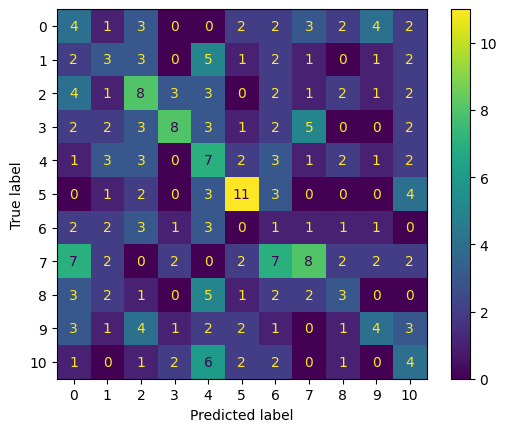

In [282]:
display_result_metrics(actual_label, predicted_label)